In [12]:
# Import Libraries 

import xgboost as xgb
from xgboost import plot_importance
from xgboost import XGBRegressor
from xgboost import plot_importance


import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV


In [13]:
# Read the excel data file
dataset = pd.read_excel("./decisiontree_data.xlsx",sheet_name="Column")
dataset = dataset.drop(["Col_ID","Bldg_Steel"],axis=1)
dataset.head()


,Bldg_Id,Bldg_Year,Bldg_Region,Bldg_Usage,Bldg_Sp_Floors,Bldg_Sb_Floors,Bldg_Gross_Area,Bldg_St_Type,Bldg_Height,Bldg_Conc,...,Fn_Depth,Fn_Material,Fn_Insullation,E_Span,W_Span,N_Span,S_Span,Prmtr,St_Width,St_Depth
0,1,2015.0,2,1,6,1,896.91,1,20.2,1.0,...,450.0,NaN,NaN,7.275,0.000,0.0,5.10,1,900,400
1,1,2015.0,2,1,6,1,896.91,1,20.2,1.0,...,400.0,NaN,0.0,0.000,7.275,0.0,0.00,1,1400,400
2,1,2015.0,2,1,6,1,896.91,1,20.2,1.0,...,900.0,0.0,0.0,6.125,0.000,5.1,0.00,0,400,900
3,1,2015.0,2,1,6,1,896.91,1,20.2,1.0,...,400.0,0.0,0.0,3.000,6.125,0.0,4.55,0,600,400
4,1,2015.0,2,1,6,1,896.91,1,20.2,1.0,...,400.0,0.0,0.0,0.000,3.000,0.0,0.00,1,675,400


In [14]:
# Define an MAPE function
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

In [7]:
# Develop machine learning models for each of buildings and calculate the mape 

building_id = np.arange(1,21,1)
train_mape_list = []
test_mape_list = []
y_test_list = []

for i in building_id:
    
    from xgboost import XGBRegressor

    df_1_Ltest = dataset[dataset["Bldg_Id"]==i]
    df_1_train = dataset[dataset["Bldg_Id"]!=i]

    # Remove the columns of Building Id and structural width (Structural depth model)

    df_1_train = df_1_train.drop(["Bldg_Id", "St_Width"], axis = 1)
    df_1_Ltest = df_1_Ltest.drop(["Bldg_Id", "St_Width"], axis = 1)
    
    Y1 = df_1_train['St_Depth']
    X1 = df_1_train.drop(["St_Depth"],axis=1)
    
    x1_train, x1_test, y1_train, y1_test = train_test_split(X1.values, Y1.values, test_size=0.2, random_state=1234)

    param_grid = {
    'learning_rate': np.arange(0.01, 0.3, 0.01),
    'n_estimators': np.arange(50, 1000, 50),
    'max_depth': np.arange(3, 10, 1),
    'min_child_weight': np.arange(1, 10, 1),
    'gamma': np.arange(0, 0.5, 0.1),
    'subsample': np.arange(0.5, 1.0, 0.1),
    'colsample_bytree': np.arange(0.5, 1.0, 0.1),
    'reg_lambda': np.arange(0, 1, 0.1),
    'reg_alpha': np.arange(0, 1, 0.1)}   
    
    #xgb_model = xgb.XGBRegressor(tree_method = 'gpu_hist', gpu_id = 0) #GPU 
    xgb_model = xgb.XGBRegressor(tree_method = 'hist') #CPU 

    
    
    random_search = RandomizedSearchCV(xgb_model, param_distributions=param_grid, n_iter=100, cv=5, verbose=1, scoring='neg_mean_absolute_error', random_state=1234)
    random_search.fit(x1_train, y1_train)
    
    print("Best prameters fournd:", random_search.best_params_)
    print("Lowest RMSE foud: ", np.sqrt(np.abs(random_search.best_score_)))
    
    model = random_search.best_estimator_
    y1_pred = model.predict(x1_test)
    
    train_mape = mape(y1_test, y1_pred)
    train_mape_list.append(train_mape)
    
    Y1_Ltetst = df_1_Ltest['St_Depth']
    X1_Ltest = df_1_Ltest.drop(["St_Depth"], axis=1)   
    
    y1_pred_Ltest = model.predict(X1_Ltest)
    test_mape = mape(Y1_Ltetst, y1_pred_Ltest)
    
    test_mape_list.append(test_mape)
    y_test_list.append(y1_pred_Ltest)
    
    print("Complete building: {}".format (i))
    

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best prameters fournd: {'subsample': 0.7999999999999999, 'reg_lambda': 0.2, 'reg_alpha': 0.9, 'n_estimators': 750, 'min_child_weight': 1, 'max_depth': 6, 'learning_rate': 0.14, 'gamma': 0.4, 'colsample_bytree': 0.8999999999999999}
Lowest RMSE foud:  3.3635664227062816
Complete building: 1
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best prameters fournd: {'subsample': 0.7999999999999999, 'reg_lambda': 0.2, 'reg_alpha': 0.9, 'n_estimators': 750, 'min_child_weight': 1, 'max_depth': 6, 'learning_rate': 0.14, 'gamma': 0.4, 'colsample_bytree': 0.8999999999999999}
Lowest RMSE foud:  3.134302466834081
Complete building: 2
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best prameters fournd: {'subsample': 0.7999999999999999, 'reg_lambda': 0.4, 'reg_alpha': 0.2, 'n_estimators': 300, 'min_child_weight': 1, 'max_depth': 9, 'learning_rate': 0.14, 'gamma': 0.2, 'colsample_bytree': 0.8999999999999999}
L

In [8]:
mean = sum(train_mape_list) / len(train_mape_list)
print(mean)


1.1775329897125186


In [9]:
mean = sum(test_mape_list) / len(test_mape_list)
print(mean)


13.993601349025113


In [11]:
test_mape_list

[8.263840423233209,
 16.90132431030273,
 10.684255981445311,
 36.42574098618976,
 14.017051696777342,
 7.444644029809052,
 28.120697844521864,
 15.337347507476807,
 11.224530854293603,
 2.9323350320130714,
 0.8921386718750001,
 7.3862168375651045,
 25.128428293158393,
 7.876961473105612,
 24.71090316061648,
 11.571175379534953,
 17.770651499430336,
 1.9405980682373043,
 26.567755574965286,
 4.675429355951002]

In [10]:
# MAPE for all data 

y_test_result = np.concatenate(y_test_list)

y_actual = np.array(dataset["St_Depth"])

mape(y_actual, y_test_result)

72.90349308325705

In [9]:
dataset["Predicted_Depth"] = y_test_result

In [16]:
# Develop machine learning models for each of buildings and calculate the mape 

building_id = np.arange(1,21,1)
train_width_mape_list = []
test_width_mape_list = []
y_width_test_list = []

for i in building_id:
    
    from xgboost import XGBRegressor

    df_1_width_Ltest = dataset[dataset["Bldg_Id"]==i]
    df_1_width_train = dataset[dataset["Bldg_Id"]!=i]

    # Remove the columns of Building Id and structural width (Structural depth model)

    df_1_width_train = df_1_width_train.drop(["Bldg_Id", "St_Depth"], axis = 1)
    #df_1_width_train = df_1_width_train.drop(["Predicted_Depth"], axis = 1)

    df_1_width_Ltest = df_1_width_Ltest.drop(["Bldg_Id", "St_Depth"], axis = 1)
    #df_1_width_Ltest = df_1_width_Ltest.drop(["Predicted_Depth"], axis = 1)
    
    Y1_width = df_1_width_train['St_Width']
    X1_width = df_1_width_train.drop(["St_Width"],axis=1)
    
    x1_train_width, x1_test_width, y1_train_width, y1_test_width = train_test_split(X1_width.values, Y1_width.values, test_size=0.2, random_state=1234)

    param_grid = {
    'learning_rate': np.arange(0.01, 0.3, 0.01),
    'n_estimators': np.arange(50, 1000, 50),
    'max_depth': np.arange(3, 10, 1),
    'min_child_weight': np.arange(1, 10, 1),
    'gamma': np.arange(0, 0.5, 0.1),
    'subsample': np.arange(0.5, 1.0, 0.1),
    'colsample_bytree': np.arange(0.5, 1.0, 0.1),
    'reg_lambda': np.arange(0, 1, 0.1),
    'reg_alpha': np.arange(0, 1, 0.1)}   
    
    #xgb_model = xgb.XGBRegressor(tree_method = 'gpu_hist', gpu_id = 0) #GPU 
    xgb_model = xgb.XGBRegressor(tree_method = 'hist') #CPU 

    
    
    random_search = RandomizedSearchCV(xgb_model, param_distributions=param_grid, n_iter=100, cv=5, verbose=1, scoring='neg_mean_absolute_error', random_state=1234)
    random_search.fit(x1_train_width, y1_train_width)
    
    print("Best prameters fournd:", random_search.best_params_)
    print("Lowest RMSE foud: ", np.sqrt(np.abs(random_search.best_score_)))
    
    model_width = random_search.best_estimator_
    y1_pred_width = model_width.predict(x1_test_width)
    
    train_width_mape = mape(y1_test_width, y1_pred_width)
    train_width_mape_list.append(train_width_mape)
    
    Y1_width_Ltetst = df_1_width_Ltest['St_Width']
    X1_width_Ltest = df_1_width_Ltest.drop(["St_Width"], axis=1)   
    
    y1_width_pred_Ltest = model_width.predict(X1_width_Ltest)
    test_width_mape = mape(Y1_width_Ltetst, y1_width_pred_Ltest)
    
    test_width_mape_list.append(test_width_mape)
    y_width_test_list.append(y1_width_pred_Ltest)
    
    print("Complete building: {}".format (i))
    

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best prameters fournd: {'subsample': 0.8999999999999999, 'reg_lambda': 0.0, 'reg_alpha': 0.0, 'n_estimators': 350, 'min_child_weight': 1, 'max_depth': 6, 'learning_rate': 0.15000000000000002, 'gamma': 0.30000000000000004, 'colsample_bytree': 0.7}
Lowest RMSE foud:  1.8706722183805247
Complete building: 1
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best prameters fournd: {'subsample': 0.8999999999999999, 'reg_lambda': 0.0, 'reg_alpha': 0.0, 'n_estimators': 350, 'min_child_weight': 1, 'max_depth': 6, 'learning_rate': 0.15000000000000002, 'gamma': 0.30000000000000004, 'colsample_bytree': 0.7}
Lowest RMSE foud:  2.171117008464033
Complete building: 2
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best prameters fournd: {'subsample': 0.8999999999999999, 'reg_lambda': 0.0, 'reg_alpha': 0.0, 'n_estimators': 350, 'min_child_weight': 1, 'max_depth': 6, 'learning_rate': 0.15000000000000002, 'gamma':

In [17]:
mean = sum(train_width_mape_list) / len(train_width_mape_list)
print(mean)


0.9316899878354337


In [18]:
mean = sum(test_width_mape_list) / len(test_width_mape_list)
print(mean)


12.316478227357132


In [19]:
test_width_mape_list

[10.7940096591559,
 14.960580444335935,
 7.166184997558594,
 12.088909843232896,
 10.958074781629774,
 14.207507959175935,
 21.19236531799093,
 12.59148063659668,
 12.321748807832792,
 11.385302365481198,
 15.998330010308162,
 8.48283973330543,
 2.7721573043655563,
 10.041062396505607,
 20.29912559714623,
 11.54594211952359,
 26.346965365939674,
 2.0008240509033204,
 13.265330502089636,
 7.910822654064792]

In [20]:
# MAPE for all data 

y_test_result_width = np.concatenate(y_width_test_list)

y_actual = np.array(dataset["St_Depth"])

mape(y_actual, y_test_result_width)

43.756208246322316

In [ ]:
dataset["Predicted_Width"] = y_test_result_width

In [10]:
dataset.to_excel('Column_Prediction.xlsx', index=False)

<AxesSubplot: xlabel='Feature'>

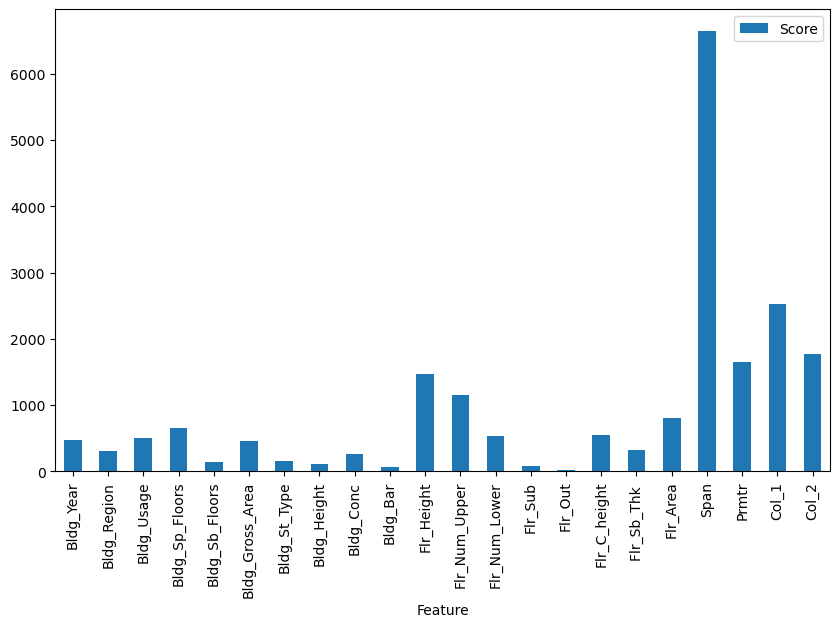

In [11]:

# Get the feature importance scores
scores = model.get_booster().get_score(importance_type='weight')

# Create a Pandas DataFrame with the scores
scores_df = pd.DataFrame(list(scores.items()), columns=['Feature', 'Score'])
scores_df['Feature']= X1.columns

# Plot the feature importance scores
scores_df.plot(x='Feature', y='Score', kind='bar', figsize=(10, 6))
